In [23]:
import random
import torch
from d2l import torch as d2l

tokens  = d2l.tokenize( d2l.read_time_machine() )#注意，返回是以'word'为单位的词元列表
#将二维文本列表展成一维列表
corpus  = [  token  for lines in tokens  for token in lines  ]

vocab = d2l.Vocab( corpus )
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

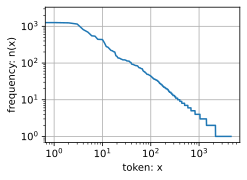

In [24]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')#满足齐普夫定律


In [25]:
#英语里pair有一双一对的意思
bigram_tokens = [ pair  for pair in zip( corpus[:-1] , corpus[1:]) ]#这一段很有意思。去掉最后一个词元的列表与去掉第一个词元的列表进行zip，
                                                                    #返回的相互匹配的二元元祖
bigram_vocab = d2l.Vocab( bigram_tokens )
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [26]:
#看看三元组
trigram_tokens = [ triple for triple in zip( corpus[:-2] , corpus[1:-1] , corpus[ 2: ]  )]
trigram_vocab  = d2l.Vocab( trigram_tokens )
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

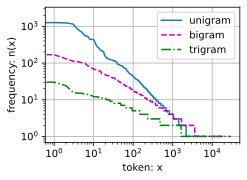

In [27]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])


In [28]:
#随机采样
def seq_data_iter_random( corpus ,  batch_size , num_steps ):
    #首先我们要使用随机偏移量对总序列进行分区，随机范围包括`num_steps - 1`
    corpus  = corpus[random.randint( 0 , num_steps-1 ) : ]#这个是很有意思的，移个位就能产生相同索引下不同词元的效果
    #第二，我们求出以num_steps长度的长序列的个数，也就是用(总的corpus的长度  - 1) // num_steps,这里减去1是因为考虑到
    #标签
    num_subseqs = ( len( corpus ) - 1 ) // num_steps 
    # 长度为`num_steps`的子序列的起始索引,生成列表的每个元素都是当前子序列的起始索引
    initial_indices = list( range( 0 , num_steps*num_subseqs , num_steps ) )
    #随机打乱索引顺序，保证相邻的序列不一定连续
    random.shuffle( initial_indices )
    #这个函数就是用来提取子序列，得到一个列表
    def data( pos ):
        # 返回从`pos`位置开始的长度为`num_steps`的序列
        return corpus[ pos : pos + num_steps  ]
    #将长序列个数整除批次大小，得到批次数num_batches
    num_batches = num_subseqs  // batch_size 

    for i in range( 0 , batch_size*num_batches , batch_size ):
        #得到每个batch长度的长序列起始索引的列表
        initial_indices_pre_batch = initial_indices [ i : i+batch_size ]

        X = [ data( j) for j in initial_indices_pre_batch ]
        #这里j+1非常精妙，这样就得到了移1位的子序列，从X序列推断Y序列，就是我们想要的数据集
        Y = [ data( j+1 ) for j in initial_indices_pre_batch ]
        
        yield torch.tensor( X ) , torch.tensor( Y )
        

In [29]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[12, 13, 14, 15, 16],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]])
X:  tensor([[ 2,  3,  4,  5,  6],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]])


In [30]:
#顺序采样
def seq_data_iter_sequential( corpus ,  batch_size , num_steps ):
    #首先我们要使用随机偏移量对总序列进行分区，随机范围包括`num_steps - 1`
    corpus  = corpus[random.randint( 0 , num_steps-1 ) : ]#这个是很有意思的，移个位就能产生相同索引下不同词元的效果
    #第二，我们求出以num_steps长度的长序列的个数，也就是用(总的corpus的长度  - 1) // num_steps,这里减去1是因为考虑到
    #标签
    num_subseqs = ( len( corpus ) - 1 ) // num_steps 
    # 长度为`num_steps`的子序列的起始索引,生成列表的每个元素都是当前子序列的起始索引
    initial_indices = list( range( 0 , num_steps*num_subseqs , num_steps ) )

    #这个函数就是用来提取子序列，得到一个列表
    def data( pos ):
        # 返回从`pos`位置开始的长度为`num_steps`的序列
        return corpus[ pos : pos + num_steps  ]
    #将长序列个数整除批次大小，得到批次数num_batches
    num_batches = num_subseqs  // batch_size 

    for i in range( 0 , batch_size*num_batches , batch_size ):
        #得到每个batch长度的长序列起始索引的列表
        initial_indices_pre_batch = initial_indices [ i : i+batch_size ]

        X = [ data( j) for j in initial_indices_pre_batch ]
        #这里j+1非常精妙，这样就得到了移1位的子序列，从X序列推断Y序列，就是我们想要的数据集
        Y = [ data( j+1 ) for j in initial_indices_pre_batch ]
        
        yield torch.tensor( X ) , torch.tensor( Y )

In [31]:
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=4, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10],
        [11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]])


In [32]:
class SeqDataLoader:
    def __init__( self  , batch_size , num_steps , use_random_iter , max_tokens ):
        if use_random_iter:
            self.data_iter_func = seq_data_iter_random
        else:
            self.data_iter_func = seq_data_iter_sequential
        self.batch_size , self.num_steps = batch_size , num_steps
        #仍然要记住，返回的是全部文本的索引和词汇表
        self.corpus , self.vocab = d2l.load_corpus_time_machine()
    
    def __iter__( self ):
        #返回一个数据生成器，生成器又是一种特殊的迭代器
        return self.data_iter_func( self.corpus , self.batch_size , self.num_steps )

In [21]:
def load_data_time_machine( batch_size ,  num_steps ,  use_random_iter=False,
                          max_tokens=10000 ):
    data_iter =  SeqDataLoader( 
                        batch_size , num_steps ,  use_random_iter , max_tokens )
    #返回数据可迭代对象和词汇表
    return data_iter , data_iter.vocab

In [22]:
data_iter , _ = load_data_time_machine( 2 , 5 )


In [40]:
#实际上这里为什么要用iter，明明返回的应该是Generator呀，生成器是不需要iter()就可以直接next()的。实际上这里是一个非常基础的python问题，
#就是我们调用iter()实际上就是在调用data_iter.__iter__(),也就是说这个data_iter实际上是个可迭代对象而已，我们需要iter()取到数据流。
next( iter( data_iter ) )

(tensor([[ 2,  1,  3,  5, 13],
         [ 2,  1, 13,  4, 15]]),
 tensor([[ 1,  3,  5, 13,  2],
         [ 1, 13,  4, 15,  9]]))

In [52]:
from collections import Iterable , Iterator
isinstance( data_iter , Iterable) , isinstance( data_iter , Iterator )

D:\CONDA\envs\d2l\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


(True, False)

In [50]:
next( data_iter.__iter__() )

(tensor([[ 3,  5, 13,  2,  1],
         [13,  4, 15,  9,  5]]),
 tensor([[ 5, 13,  2,  1, 13],
         [ 4, 15,  9,  5,  6]]))